- make a classifier network that is as similar as possible to the umap subclass

In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load packages

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile
from datetime import datetime


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [5]:
from tfumap.load_datasets import load_MOONS, mask_labels

In [6]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_MOONS(noise= 0.1)

In [7]:
labels_per_class = 5
X_labeled, Y_labeled, Y_masked = mask_labels(X_train, Y_train, labels_per_class = labels_per_class)

(2000, 10, 1000)

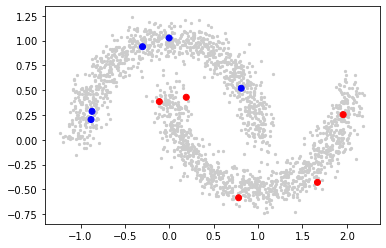

In [8]:
plt.scatter(X_train[:,0], X_train[:,1], color='#CCCCCC', s=5)
plt.scatter(X_labeled[:,0], X_labeled[:,1], c=Y_labeled, cmap = plt.cm.bwr)
len(X_train), len(X_labeled), len(X_valid)

### Build umap graph

In [9]:
from tfumap.semisupervised import build_fuzzy_simplicial_set

In [10]:
n_neighbors = 15 # default = 15
umap_graph = build_fuzzy_simplicial_set(X_train, y= Y_masked, n_neighbors=n_neighbors)

### Build data iterators

In [11]:
from tfumap.umap import compute_cross_entropy, get_graph_elements
from tfumap.semisupervised import create_edge_iterator, create_validation_iterator, create_classification_iterator

In [12]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 1000])
batch_size

1000

In [13]:
labeled_iter = create_classification_iterator(X_labeled, Y_labeled, batch_size=batch_size)

In [14]:
max_sample_repeats_per_epoch = 25
edge_iter, n_edges_per_epoch = create_edge_iterator(
    head,
    tail,
    weight,
    batch_size=batch_size,
    max_sample_repeats_per_epoch=max_sample_repeats_per_epoch,
)

In [15]:
data_valid, n_valid_samp = create_validation_iterator(X_valid, Y_valid, batch_size)

### Build network

In [16]:
from tensorflow.keras import layers

In [17]:
dims = (2)
num_classes = 2
PROJECTION_DIMS = 2

In [18]:
encoder = tf.keras.Sequential()
encoder.add(tf.keras.Input(shape=dims))
encoder.add(layers.Dense(100, activation='relu'))
encoder.add(layers.Dense(100, activation='relu'))
encoder.add(layers.Dense(100, activation='relu'))

In [19]:
classifier = tf.keras.Sequential()
classifier.add(tf.keras.Input(shape=(100)))
classifier.add(layers.Dense(100, activation='relu'))
classifier.add(layers.Dense(num_classes, activation=None, name="predictions"))

In [20]:
embedder = tf.keras.Sequential()
embedder.add(tf.keras.Input(shape=(100)))
embedder.add(layers.Dense(100, activation='relu'))
embedder.add(layers.Dense(PROJECTION_DIMS, activation=None, name='z'))

### Create UMAP object

In [21]:
from tfumap.umap import compute_cross_entropy, convert_distance_to_probability

In [22]:
from tfumap.semisupervised import find_a_b, compute_umap_loss, compute_classifier_loss

In [23]:
class PUMAP(tf.keras.Model):
    def __init__(
        self,
        encoder,
        embedder,
        classifier,
        tensorboard_logdir=None,  # directory for tensorboard log
        min_dist=0.1,
        negative_sample_rate=5.0,
        optimizer=tf.keras.optimizers.SGD(0.1),
        repulsion_strength=1.0,
        # ** kwargs,
    ):
        super(PUMAP, self).__init__()
        # self.__dict__.update(kwargs)

        # subnetworks
        self.embedder = embedder
        self.encoder = encoder
        self.classifier = classifier

        # optimizer for cross entropy minimization
        self.optimizer = optimizer
        self.classifier_optimizer = tf.keras.optimizers.Adam(0.01)
        self.repulsion_strength = repulsion_strength
        self.negative_sample_rate = negative_sample_rate

        # get a,b for current min_dist
        self._a, self._b = find_a_b(min_dist)

        # create summary writer to log loss information during training
        if tensorboard_logdir is None:
            self.tensorboard_logdir = os.path.join(
                tempfile.gettempdir(),
                "tensorboard",
                datetime.now().strftime("%Y%m%d-%H%M%S"),
            )
        else:
            self.tensorboard_logdir = tensorboard_logdir
        self.summary_writer_train = tf.summary.create_file_writer(
            self.tensorboard_logdir + "/train"
        )
        self.summary_writer_valid = tf.summary.create_file_writer(
            self.tensorboard_logdir + "/valid"
        )

        # create a loss dictionary
        self.loss_df = pd.DataFrame(
            columns=[
                "epoch",
                "type_",
                "attraction_loss",
                "repellant_loss",
                "umap_loss",
                "classifier_loss",
            ]
        )

        # sparse categorical cross entropy
        self.sparse_ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.create_summary_metrics()

    def create_summary_metrics(self):

        """
        Create keras summary objects for loss
        """
        self.summary_metrics = {}
        self.summary_metrics["train_loss_umap"] = tf.keras.metrics.Mean(
            "train_loss_umap", dtype=tf.float32
        )
        self.summary_metrics["train_loss_classif"] = tf.keras.metrics.Mean(
            "train_loss_classif", dtype=tf.float32
        )
        self.summary_metrics["valid_loss_classif"] = tf.keras.metrics.Mean(
            "valid_loss_classif", dtype=tf.float32
        )

    def write_losses(self, batch, classif_loss, umap_loss=None, train=True):
        # add umap loss
        if train:
            summary_writer = self.summary_writer_train
            train_valid = "train"
            self.summary_metrics[train_valid + "_loss_umap"](umap_loss)
        else:
            summary_writer = self.summary_writer_valid
            train_valid = "valid"

        # add valid loss
        self.summary_metrics[train_valid + "_loss_classif"](classif_loss)

        # write loss
        with summary_writer.as_default():
            if train:
                tf.summary.scalar(
                    "umap_loss",
                    self.summary_metrics[train_valid + "_loss_umap"].result(),
                    step=batch,
                )
            tf.summary.scalar(
                "classif_loss",
                self.summary_metrics[train_valid + "_loss_classif"].result(),
                step=batch,
            )
            summary_writer.flush()

    def save_losses(self, losses, epoch, type_="training"):
        """ Save losses into a pandas dataframe
        """
        attraction_loss, repellant_loss, umap_loss, classifier_loss = losses

        # get average loss
        attraction_loss = tf.reduce_mean(attraction_loss).numpy()
        repellant_loss = tf.reduce_mean(repellant_loss).numpy()
        umap_loss = tf.reduce_mean(umap_loss).numpy()
        classifier_loss = tf.reduce_mean(classifier_loss).numpy()

        # save loss
        self.loss_df.loc[len(self.loss_df)] = [
            epoch,
            type_,
            attraction_loss,
            repellant_loss,
            umap_loss,
            classifier_loss,
        ]

    @tf.function
    def train(self, batch_to, batch_from, X, y, save_loss=False):
        """ One training step 
        Input are points and weights for positive and negative 
        samples for training. 
            
        """
        with tf.GradientTape() as umap_tape, tf.GradientTape() as class_tape:
            (attraction_loss, repellant_loss, umap_loss) = compute_umap_loss(
                batch_to,
                batch_from,
                self.embedder,
                self.encoder,
                self._a,
                self._b,
                self.negative_sample_rate,
                self.repulsion_strength,
            )

            classifier_loss = compute_classifier_loss(
                X, y, self.encoder, self.classifier, self.sparse_ce
            )

        # compute gradient for umap
        umap_grad = umap_tape.gradient(
            umap_loss,
            self.encoder.trainable_variables + self.embedder.trainable_variables,
        )

        # gradients are cliped in UMAP implementation. Any effect here?
        umap_grad = [tf.clip_by_value(grad, -4.0, 4.0) for grad in umap_grad]

        self.optimizer.apply_gradients(
            zip(
                umap_grad,
                self.encoder.trainable_variables + self.embedder.trainable_variables,
            )
        )

        # compute gradient for classifier
        class_grad = class_tape.gradient(
            classifier_loss, self.classifier.trainable_variables
        )

        # gradients are cliped in UMAP implementation. Any effect here?
        class_grad = [tf.clip_by_value(grad, -4.0, 4.0) for grad in class_grad]

        self.classifier_optimizer.apply_gradients(
            zip(class_grad, self.classifier.trainable_variables)
        )

        return (attraction_loss, repellant_loss, umap_loss, classifier_loss)

    # @tf.function
    def project_epoch(self, X):
        """ Train a batch in tensorflow
        """
        return [self.embedder(self.encoder(batch)) for batch in X]

    def get_dataset_loss(self,dataset):
        return [
            compute_classifier_loss(X, y, self.encoder, self.classifier, self.sparse_ce)
            for X, y in dataset
        ]

In [24]:
### Initialize model
model = PUMAP(
    min_dist = 0.0,
    negative_sample_rate = 5, # how many negative samples per positive
    optimizer=tf.keras.optimizers.Adam(1e-2), # cross-entropy optimizer
    encoder=encoder,
    embedder=embedder,
    classifier=classifier,
)

### plotting results

In [25]:
from tfumap.semisupervised_plotting import plot_umap_classif_results
from tfumap.semisupervised_plotting import get_decision_contour

W0726 13:48:10.821810 139972120397632 base_layer.py:1790] Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



No objects to concatenate


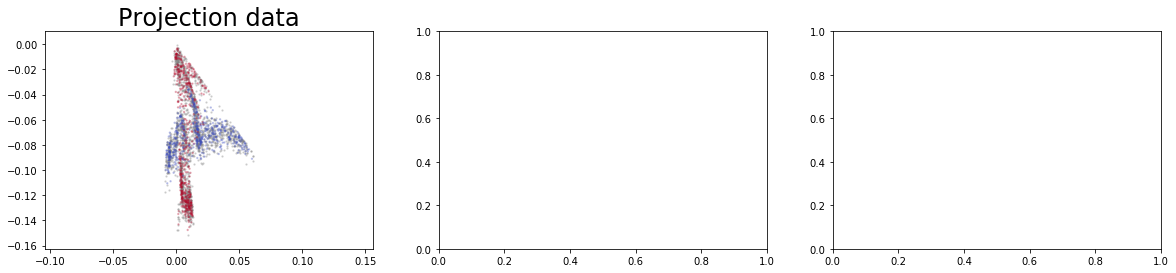

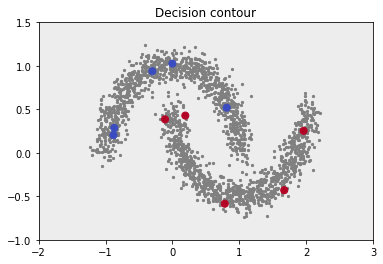

In [26]:
plot_umap_classif_results(model, X_valid, Y_valid, X_train, batch_size)
fig, ax = plt.subplots()
ax = get_decision_contour(
    ax, model, X_valid, X_train, X_labeled, Y_labeled, samplerate = 100, color="grey", s=5, decision_alpha=0.5#0
)
plt.show()

### Train model

In [27]:
batch = 0; epoch = 0
N_EPOCHS = 50 # total number of epochs
SAMPLE_EPOCHS = np.linspace(0, N_EPOCHS-1, 10).astype('int') # how often to plot
print(SAMPLE_EPOCHS[:10])
BATCHES_PER_EPOCH = int(n_edges_per_epoch / batch_size)
TOTAL_BATCHES = BATCHES_PER_EPOCH * N_EPOCHS

[ 0  5 10 16 21 27 32 38 43 49]


In [28]:
BATCHES_PER_EPOCH

394

In [29]:
for edge_epoch, epoch in tqdm(zip(edge_iter, np.arange(N_EPOCHS)), total=N_EPOCHS):
    
    # validation loss
    classif_loss = model.get_dataset_loss(data_valid)
    model.write_losses(
            batch=batch, classif_loss=classif_loss, umap_loss=None, train=False
        )
    
    # train
    for (batch_to, batch_from), (X, y) in tqdm(
        zip(edge_epoch, labeled_iter), total=BATCHES_PER_EPOCH, leave=False
    ):
        batch_to = X_train[batch_to]
        batch_from = X_train[batch_from]
        # train model
        losses = model.train(batch_to=batch_to, batch_from=batch_from, X=X, y=y)
        model.write_losses(
            batch=batch, classif_loss=losses[3], umap_loss=losses[2], train=True
        )
        model.save_losses(losses, epoch=epoch, type_="train")
    # plot
    if epoch in SAMPLE_EPOCHS:
        print("batch: {}".format(batch))
        #plot_results(
        #    model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size, dims
        #)

    batch += BATCHES_PER_EPOCH
    # batch_tqdm.update(BATCHES_PER_EPOCH)

batch: 0



NameError: name 'plot_results' is not defined

In [ ]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [ ]:
from tfumap.semisupervised_plotting import embed_data

In [ ]:
loss_df = retrieve_tensors(model.tensorboard_logdir)
loss_df

In [ ]:
embedding_valid = embed_data(X_valid, model, batch_size)
embedding_train = embed_data(X_train, model, batch_size)

In [ ]:
plot_umap_classif_results(model, X_valid, Y_valid, X_train, batch_size)

In [ ]:
fig, ax = plt.subplots()
ax = get_decision_contour(
    ax, model, X_valid, X_train, X_labeled, Y_labeled, samplerate = 100, color="grey", s=5, decision_alpha=0.5#0
)